# Spike timing dependent plasticity (STDP) rules

## Initialization

In [159]:
!pip install numpy scipy matplotlib ipywidgets scikit-learn --quiet
import numpy as np
import scipy.linalg as lin
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.style.use("https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/plots_style.txt")

## Plotting the pairwise STDP rule

In [160]:
def pairSTDP_plot(A_plus, A_minus, tau_plus, tau_minus, Delta_t, dW):
  
  '''
  Generates a plot for the pairwise STDP rule

  A_plus : maximum amount of potentiation (LTP)
  A_minus: maximum amount of depression (LTD)
  tau_plus: LTP time constant
  tau_minus: LTD time constant 
  Delta_t : array with the time differences between post- and pre-synaptic spikes
  dW : synaptic change 
  
  '''
  plt.figure()
  plt.plot([-5 * tau_minus, 5 * tau_plus], [0, 0], 'k', linestyle=':')
  plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

  plt.plot(Delta_t[Delta_t <= 0], dW[Delta_t <= 0], 'r')
  plt.plot(Delta_t[Delta_t > 0], dW[Delta_t > 0], 'b')

  plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)')
  plt.ylabel(r'$\Delta $W', fontsize=14)
  plt.title('Pairwise STDP rule', fontsize=16, fontweight='bold')
  plt.show()

In [161]:
def Delta_W_pairSTDP(A_plus, A_minus, tau_plus, tau_minus, Delta_t):
  """
  Calculates the instantaneous change in weights dW due to the STDP pairwise rule

  A_plus : maximum amount of potentiation (LTP)
  A_minus: maximum amount of depression (LTD)
  tau_plus: LTP time constant
  tau_minus: LTD time constant 
  Delta_t : array with the time differences between post- and pre-synaptic spikes
  """

  # Initialize the STDP change
  dW = np.zeros(len(Delta_t))
  # Calculate dW for LTP
  dW[Delta_t > 0] = A_plus * np.exp(-Delta_t[Delta_t > 0] / tau_plus)
  # Calculate dW for LTD
  dW[Delta_t <= 0] = -A_minus * np.exp(Delta_t[Delta_t <= 0] / tau_minus)

  return dW

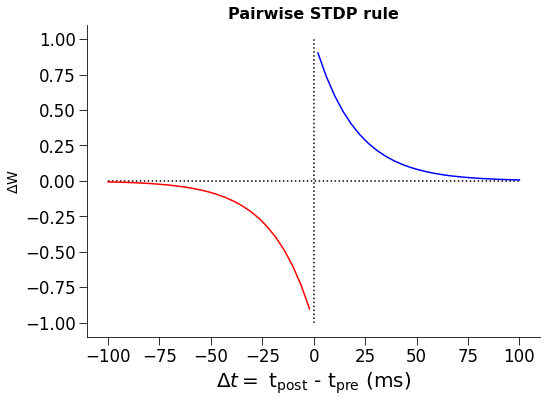

In [162]:
'''
Main
'''
# define the STDP rule parameters
A_plus = 1
A_minus = 1
tau_plus = 20  #[ms]
tau_minus = 20 #[ms]

Delta_t = np.linspace(-5 * tau_minus, 5 * tau_plus, 50)

dW = Delta_W_pairSTDP(A_plus, A_minus, tau_plus, tau_minus, Delta_t)

pairSTDP_plot(A_plus, A_minus, tau_plus, tau_minus, Delta_t, dW)


## Plot detector traces and spike trains 
study only the case of 1 pre- and 1 postsynaptic neuron (Poisson neurons).

In [171]:
def Poisson_spike_train(discretization_step, t_range, rate, myseed):
    """Generates poisson train
    Args:
    discretization_step    :
    t_range 
    rate                   : noise amplitute [Hz]
    myseed                 : random seed. int or boolean

    Returns:
    spike_train : spike train of binary values (1 if spike, 0 otherwise)
    """
    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    unirnd = np.random.rand(len(t_range))

    # generate Poisson train
    poisson_train = 1. * (unirnd < rate * (discretization_step))

    return poisson_train

In [182]:
taup = 20e-3  #[ms]
taum = 20e-3 #[ms]

discretization_step=1e-4
t_range=np.arange(0,3,discretization_step)
pre_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=2020)
post_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=2000)

#pre_spike = np.reshape(pre_spike, len(t_range))

r1=np.zeros(len(t_range))        # presynaptic event detector
o1=np.zeros(len(t_range))        # postsynaptic event detector

for i in range(len(t_range)-1):
    if pre_spike[i]==1:     # there is a pre-synaptic spike
        r1[i]+= 1
        
    if post_spike[i]==1:    # there is a post-synaptic spike
        o1[i] += 1
    # Apply Euler's method to the detector equations
    r1[i+1] = r1[i] - discretization_step * r1[i]/taup
    o1[i+1] = o1[i] - discretization_step * o1[i]/taum

(-0.14999500000000002, 3.1498950000000003, -0.05, 1.05)

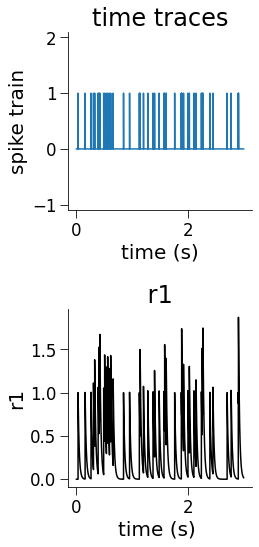

In [184]:




# set up the plots correctly!!

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4,8)) #gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(t_range,pre_spike)
ax1.set_xlabel("time (s)")
ax1.set_ylabel("spike train")
ax1.set_title("time traces")
ax2.plot(t_range,r1,color="black")
ax2.set_title(" r1 ")
ax2.set_xlabel("time (s) ")
ax2.set_ylabel("r1")
ax1.axis("equal")

## Plotting the triplet STDP rule

In [163]:
def tripletSTDP_plot(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t1, Delta_t2, dW):
    '''
    Generates a plot for the pairwise STDP rule

    A_plus : maximum amount of potentiation (LTP)
    A_minus: maximum amount of depression (LTD)
    tau_plus: LTP time constant
    tau_minus: LTD time constant 
    tau_y: second LTP time constant
    Delta_t1 : array with the time differences between the first postsynaptic spike and the presynaptic spike
    Delta_t2 : array with the time differences between the postsynaptic spikes   dW : synaptic change 
    '''

    plt.figure()
    plt.plot([-5 * tau_minus, 5 * tau_plus], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

    plt.plot(Delta_t1[Delta_t1 <= 0], dW[Delta_t1 <= 0], 'r')
    plt.plot(Delta_t1[Delta_t1 > 0], dW[Delta_t1 > 0], 'b')

    plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)')
    plt.ylabel(r'$\Delta $W', fontsize=14)
    plt.title('Triplet STDP rule', fontsize=12, fontweight='bold')
    plt.show()

In [164]:
def Delta_W_tripSTDP(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t1, Delta_t2):
    """
    Calculates the instantaneous change in weights dW due to the STDP pairwise rule

    A_plus : maximum amount of potentiation (LTP)
    A_minus: maximum amount of depression (LTD)
    tau_plus: LTP time constant
    tau_minus: LTD time constant 
    Delta_t1 : array with the time differences between the first postsynaptic spike and the presynaptic spike
    Delta_t2 : array with the time differences between the postsynaptic spikes 
    """

    # Initialize the STDP change
    dW = np.zeros(len(Delta_t1))
    # Calculate dW for LTP
    dW[Delta_t1 > 0] = A_plus * np.exp(-Delta_t1[Delta_t1 > 0] / tau_plus) * np.exp(-Delta_t2 / tau_y)
    # Calculate dW for LTD
    dW[Delta_t1 <= 0] = -A_minus * np.exp(Delta_t1[Delta_t1 <= 0] / tau_minus)

    return dW

In [165]:
'''
Main
'''
# define the STDP rule parameters
A_plus = 100
A_minus = 100
tau_plus = 20  #[ms]
tau_minus = 20 #[ms]
tau_y = 114 #[ms]

Delta_t1 = np.linspace(-5 * tau_minus, 5 * tau_plus, 50)

def triplet_STDP(Delta_t2):
    dW = Delta_W_tripSTDP(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t1, Delta_t2)

    plt.figure(figsize=(8,8))

    plt.plot([-5 * tau_minus, 5 * tau_plus], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

    plt.plot(Delta_t1[Delta_t1 < 0], dW[Delta_t1 < 0], 'r')
    plt.plot(Delta_t1[Delta_t1 >= 0], dW[Delta_t1 >= 0], 'b')

    plt.xlabel(r'$\Delta t_1=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)')
    plt.ylabel(r'$\Delta $W', fontsize=14)
    plt.title('Triplet STDP rule', fontsize=16, fontweight='bold')
    plt.plot()
    plt.show()
    

interactive_plot = interactive(mytriplet_STDP, Delta_t2=(10,100,1))
interactive_plot

interactive(children=(IntSlider(value=55, description='Delta_t2', min=10), Output()), _dom_classes=('widget-in…

## Plot detector traces and spike trains 
study only the case of 1 pre- and 1 postsynaptic neuron (Poisson neurons).

In [186]:
taup = 20e-3  #[ms]
taum = 20e-3 #[ms]
tauy = 114e-3 #[ms]

discretization_step=1e-4
t_range=np.arange(0,3,discretization_step)
pre_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=2020)
post_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=2000)

#pre_spike = np.reshape(pre_spike, len(t_range))

r1=np.zeros(len(t_range))        # presynaptic event detector
o1=np.zeros(len(t_range))        # postsynaptic event detector
o2=np.zeros(len(t_range))        # postsynaptic event detector

for i in range(len(t_range)-1):
    if pre_spike[i]==1:     # there is a pre-synaptic spike
        r1[i]+= 1
        
    if post_spike[i]==1:    # there is a post-synaptic spike
        o1[i] += 1
        o2[i] += 1
    # Apply Euler's method to the detector equations
    r1[i+1] = r1[i] - discretization_step * r1[i]/taup
    o1[i+1] = o1[i] - discretization_step * o1[i]/taum
    o2[i+1] = o2[i] - discretization_step * o2[i]/tauy

(-0.14999500000000002, 3.1498950000000003, -0.05, 1.05)

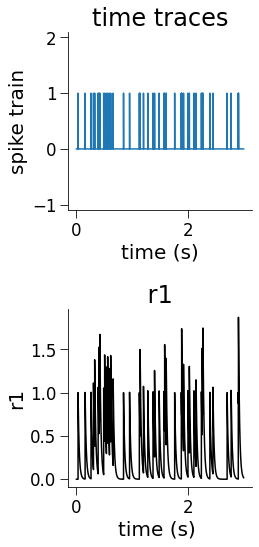

In [187]:



# set up the plots correctly!!

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4,8)) #gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(t_range,pre_spike)
ax1.set_xlabel("time (s)")
ax1.set_ylabel("spike train")
ax1.set_title("time traces")
ax2.plot(t_range,r1,color="black")
ax2.set_title(" r1 ")
ax2.set_xlabel("time (s) ")
ax2.set_ylabel("r1")
ax1.axis("equal")

## Pairing protocol helper functions

In [169]:
'''
A fixed number of pairs of presynaptic and postsynaptic spikes shifted by DeltaT are elicited at regular intervals of 1/rho. 
Plot the synaptic change due to the triplet STDP as a function of the frequency rho for a fixed DeltaT.  
'''

def spike_trains(discretization_step, rho, num_pairs):

    '''Generates presynaptic and postsynaptic spike trains characterised by a number of pairs (given by 'num_pairs') of pre- and post-synaptic spikes with a given time distance 'DeltaT'.
    The pairs are repeated at a given frequency 'rho' 

    1) Generate two "small" arrays containing only one pair of one pre- and one post-synaptic spikes within a time window 1/rho. These will be the "building blocks" of the full spike trains.

    2) Construct the full spike trains by repeating the small arrays the number of times given by num_pairs.
    '''

    DeltaT = 1e-2   # time distance between pre- and postsynaptic spikes. It must be greater than the discretization_step!
    pair_distance = round(1/rho,2)   # time distance between pairs of pre-post spikes.

    # Generate the first piece of the pre- and postsynaptic spike trains (namely, one pair of pre- and post-synaptic spikes) within a time window 1/rho 
    small_t_range = np.arange(0,pair_distance - discretization_step,discretization_step)   # time interval between pairs of pre-post spikes.
    t_range=np.arange(0,num_pairs*(pair_distance - discretization_step),discretization_step)            # the whole time interval 

    first_spike = np.zeros(len(small_t_range))           # initialize the first piece of the pre-synaptic spike train 
    second_spike = np.zeros(len(small_t_range))          # initialize the first piece of the post-synaptic spike train
    first_spike[0] = 1                                   # generate a pre-syn spike at time 0 
    second_spike[np.where(small_t_range==DeltaT)[0]] = 1 # generate a post-syn spike after DeltaT
    first_spikes=np.tile(first_spike,num_pairs)             # repeat for 'num_pairs' times and create the full spike train
    second_spikes=np.tile(second_spike,num_pairs)           # repeat for 'num_pairs' times and create the full spike train
    return first_spikes, second_spikes, t_range


def euler_exp_ode(discretization_step, x, tau):
    x = x - discretization_step * x/tau
    return x

## Pairing protocol with the pairwise STDP rule

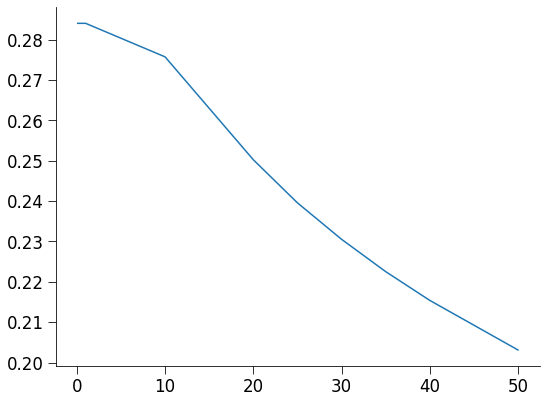

In [167]:
# Initialization 
num_pairs = 60      # number of pre- and post- pairs 
rho_vec = np.array([0.1, 1, 10, 20, 25, 30, 35, 40, 50])        # frequency values
discretization_step = 1e-4 # it must be less than the time difference within a pair of spikes DeltaT!
taup = 16.8e-3             # LTP time constant (s)
taum = 33.7e-3             # LTD time constant (s)
Aplus = 8.6e-3             # LTP window amplitude
Aminus = 2.1e-3            # LTD window amplitude
w0 = 3                     # initial weight

# initialize the synaptic change
dw = np.zeros(len(rho_vec))    

for ind,rho in enumerate(rho_vec):
    # initialize the synaptic weight
    w=w0

    pre_spike, post_spike, t_range = spike_trains(discretization_step, rho, num_pairs)
    
    # CASE with DeltaT < 0
    # The case with DeltaT < 0 is equivalent to switch the pre- and the postsynaptic spike trains.
    # post_spike, pre_spike, t_range = spike_trains(discretization_step, rho, num_pairs)

# initialize the pre- and postsynaptic detectors
    r1=0    # presynaptic event detector
    o1=0    # postsynaptic event detector

    for i,t in enumerate(t_range):
        if pre_spike[i]==1:     # there is a pre-synaptic spike
            r1 += 1
            w = w - o1*Aminus
            
        if post_spike[i]==1:    # there is a post-synaptic spike
            o1 += 1
            w = w + r1*Aplus;           
        
        # Apply Euler's method to the detector equations
        r1 = euler_exp_ode(discretization_step, r1, taup)
        o1 = euler_exp_ode(discretization_step, o1, taum)

    # Calculate the weight change as a function of the frequency
    dw[ind]= w-w0   

plt.figure()
plt.plot(rho_vec,dw)
plt.show()

## Pairing protocol with the triplet STDP rule

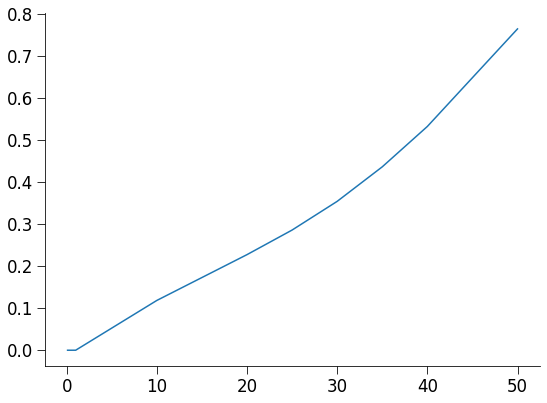

In [168]:
# Initialization 
num_pairs = 60      # number of pre- and post- pairs 
rho_vec = np.array([0.1, 1, 10, 20, 25, 30, 35, 40, 50])        # frequency values
discretization_step = 1e-4 # it must be less than the time difference within a pair of spikes DeltaT!
taup = 16.8e-3             # LTP time constant (s)
taum = 33.7e-3             # LTD time constant (s)
tauy = 114e-3              # Second LTP time constant (s)
Aplus = 6.5e-3             # LTP window amplitude
Aminus = 7.1e-3            # LTD window amplitude
w0 = 3                     # initial weight

# initialize the synaptic change
dw = np.zeros(len(rho_vec))    

for ind,rho in enumerate(rho_vec):
    # initialize the synaptic weight
    w=w0

    pre_spike, post_spike, t_range = spike_trains(discretization_step, rho, num_pairs)
    
    # CASE with DeltaT < 0
    # The case with DeltaT < 0 is equivalent to switch the pre- and the postsynaptic spike trains.
    # post_spike, pre_spike, t_range = spike_trains(discretization_step, rho, num_pairs)

# initialize the pre- and postsynaptic detectors
    r1=0    # presynaptic event detector
    o1=0    # postsynaptic event detector
    o2=0    # second postsynaptic event detector

    for i,t in enumerate(t_range):
        if pre_spike[i]==1:     # there is a pre-synaptic spike
            r1 += 1
            w = w - o1*Aminus
            
        if post_spike[i]==1:    # there is a post-synaptic spike
            o1 += 1
            w = w + r1*(Aplus*o2);           
            o2=o2+1
        
        # Apply Euler's method to the detector equations
        r1 = euler_exp_ode(discretization_step, r1, taup)
        o1 = euler_exp_ode(discretization_step, o1, taum)
        o2 = euler_exp_ode(discretization_step, o2, tauy)

    # Calculate the weight change as a function of the frequency
    dw[ind]= w-w0   

plt.figure()
plt.plot(rho_vec,dw)
plt.show()

## Inhibitory plasticity